In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.cross_validation import cross_val_score
import metrics
from sklearn.cross_validation import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from progressbar import ProgressBar
import data_grab
from time import time
from sklearn.decomposition import TruncatedSVD

from sklearn.externals import joblib
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer
from multiprocessing import Pool, Process, Manager

plt.rcParams["figure.figsize"] = (10, 8)

In [2]:
def contest_metric(numpy_array_predictions, numpy_array_actual_values):
    return metrics.weighted_rmsle(numpy_array_predictions, numpy_array_actual_values,
            weights=metrics.KEEPING_IT_CLEAN_WEIGHTS)

In [3]:
def contest_scoring(X, y, pipeline):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    s1 = pipeline.fit(X_train, y_train['score_lvl_1']).predict(X_test)
    s2 = pipeline.fit(X_train, y_train['score_lvl_2']).predict(X_test)
    s3 = pipeline.fit(X_train, y_train['score_lvl_3']).predict(X_test)
    results = np.dstack((s1, s2, s3))
    score = contest_metric(np.round(results[0]), np.array(y_test))
    print("Contest score of {}".format(score))
    return score

In [4]:
from sklearn.metrics import accuracy_score

def raw_scoring(p1, p2, p3, ytrue):
    '''since cross_val_score doesn't allow you to round the results beforehand. also for pymc3 and other non-sklearn models'''
    score1 = accuracy_score(ytrue['score_lvl_1'], np.clip(np.round(p1), 0, np.inf))
    print("Level 1 accuracy score of {}".format(score1))
    score2 = accuracy_score(ytrue['score_lvl_2'],np.clip(np.round(p2), 0, np.inf))
    print("Level 2 accuracy score of {}".format(score2))
    score3 = accuracy_score(ytrue['score_lvl_3'], np.clip(np.round(p3), 0, np.inf))
    print("Level 3 accuracy score of {}".format(score3))
    
    results = np.dstack((p1, p2, p3))[0]
    rounded = np.clip(np.round(results), 0, np.inf)
    score = contest_metric(rounded, np.array(ytrue))
    print("Contest score of {}".format(score))
    
    compare = pd.concat([pd.DataFrame(np.concatenate((results, rounded), axis=1)), ytrue.reset_index(drop=True)], axis=1)
    compare.columns = ['pred1','pred2','pred3','round1','round2','round3','true1','true2','true3']
    compare['offset1'] = compare.round1-compare.true1
    compare['offset2'] = compare.round2-compare.true2
    compare['offset3'] = compare.round3-compare.true3
        
    return score1, score2, score3, score, compare.head(10)

    
def raw_fit(X, y, pipeline):
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, random_state=42)
    
    p1 = pipeline.fit(xtrain, ytrain['score_lvl_1']).predict(xtest)
    p2 = pipeline.fit(xtrain, ytrain['score_lvl_2']).predict(xtest)
    p3 = pipeline.fit(xtrain, ytrain['score_lvl_3']).predict(xtest)
        
    return p1, p2, p3, ytest

In [5]:
def extract_features(df):
    features = df.drop(['score_lvl_1', 'score_lvl_2', 'score_lvl_3'], axis=1)
    response = df[['score_lvl_1', 'score_lvl_2', 'score_lvl_3']].astype(np.int8)
    
    return features, response

In [6]:
final = pd.read_pickle('pickle_jar/final_no_tfidf_or_restaurant_id')
# df = pd.read_pickle('pickle_jar/pre-pivot_365')
# df = pd.read_pickle('pickle_jar/pre-pivot_all_non_review')
df = pd.read_pickle('pickle_jar/post-pivot_non_review_data_365')

In [347]:
combo = pd.read_pickle('pickle_jar/pre-pivot_all_review_combo_365')

## convert train dataframe to 365 days and prepare for pivot

In [267]:
df = data_grab.get_selects('train')

In [268]:
# not getting rid of everything. not getting rid of ancient reviews if they correspond with an ancient inspection.
# just getting rid of ancient reviews in relation to a specific inspection
df = df[df.review_delta <= 365]

In [269]:
# making a column that enumerates the sorted review delta.
# removes any nans (usually marked as such because the reviews happend after an inspection date) beforehand.
# this can completely remove a restaurant if it has no reviews left after nan drop. might add back in later
df = df.sort('review_delta')
df2 = df.dropna(subset=['review_delta']).groupby('inspection_id').cumcount()

In [270]:
# df3 = pd.concat([df.dropna(subset=['review_delta']), df2], axis=1)
df = pd.concat([df.dropna(subset=['review_delta']), df2], axis=1)

In [271]:
df = df.rename(columns={0:'enumerated_review_delta'})
del df2

In [272]:
# add back in the restaurants that were completely removed because none of their reviews were
# not a significant loss in the number of restaurants. going to just leave it out for now
# mask = list(set(df.restaurant_id) - set(df3.restaurant_id))
# pd.concat([df[df.restaurant_id.isin(mask)], df3])

In [273]:
df.shape

(500936, 138)

In [86]:
just_review_data = df[[ 
 'inspection_id',
 'enumerated_review_delta',
#  'review_id',
 'review_delta', 
#  'review_date', 
 'review_stars',
 'review_text',
#  'user_id',
 'review_votes_cool',
 'review_votes_funny',
 'review_votes_useful',
 'user_average_stars',
#  'user_fans',
 'user_review_count',
#  'user_votes_cool',
#  'user_votes_funny',
#  'user_votes_useful',
 'user_yelping_since_delta',
#  'review_year',
#  'review_month',
#  'review_day',
#  'review_dayofweek',
#  'review_quarter',
#  'review_dayofyear',
 'user_ever_elite',
 ]]

In [88]:
df.drop([ 'review_delta',
 'review_stars',
 'review_text',
 'review_votes_cool',
 'review_votes_funny',
 'review_votes_useful',
 'user_average_stars',
 'user_fans',
 'user_review_count',
 'user_votes_cool',
 'user_votes_funny',
 'user_votes_useful',
 'user_yelping_since_delta',
 'user_ever_elite'], axis=1, inplace=True)
df.drop(['review_date',
 'review_id',
 'user_id',
 'user_compliments_cool',
 'user_compliments_cute',
 'user_compliments_funny',
 'user_compliments_hot',
 'user_compliments_list',
 'user_compliments_more',
 'user_compliments_note',
 'user_compliments_photos',
 'user_compliments_plain',
 'user_compliments_profile',
 'user_compliments_writer',
 'user_name', 'review_year',
 'review_month',
 'review_day',
 'review_dayofweek',
 'review_quarter',
 'review_dayofyear','user_most_recent_elite_year_delta',], axis=1, inplace=True)
df.drop('enumerated_review_delta', axis=1, inplace=True)

In [274]:
g = df.groupby('inspection_id').first()

In [275]:
# g.reset_index().sort('inspection_id').to_pickle('pickle_jar/post-pivot_full_365')

In [92]:
g.reset_index().sort('inspection_id').to_pickle('pickle_jar/post-pivot_non_review_data_365')

In [33]:
df.sort('inspection_id').to_pickle('pickle_jar/pre-pivot_all_non_review')

In [44]:
# this removes all the nans left. review stars as nans because reviews and tips combined and tips didnt give a star rating
# planning to treat this as a categorical variable later so making it zero shouldnt affect anything
just_review_data.review_stars = just_review_data.review_stars.fillna(0)

In [45]:
just_review_data.sort(['inspection_id', 'enumerated_review_delta']).to_pickle('pickle_jar/pre-pivot_365')

## combine sentiment and similarity with pre-pivot 365 review related data into one dataframe for pivoting

In [46]:
sentiment = pd.read_pickle('pickle_jar/review_text_sentiment_pivot')
similarity = pd.read_pickle('pickle_jar/similarity_length_pivot')

In [47]:
sentiment = sentiment[['inspection_id', 'enumerated_review_delta', 'polarity', 'subjectivity', 'neg', 'neu', 'pos', 'compound']]

In [48]:
similarity.drop(['review_delta', 'review_stars', 'review_text', 'review_votes_cool', 'review_votes_funny',
                 'review_votes_useful', 'user_average_stars', 'user_fans', 'user_review_count', 'user_votes_cool', 
                 'user_votes_funny', 'user_votes_useful', 'user_yelping_since_delta', 'user_ever_elite',
                 'preprocessed_review_text'], axis=1, inplace=True)

In [49]:
combo = pd.merge(sentiment, similarity, on=['inspection_id', 'enumerated_review_delta'])

In [50]:
just_review_data.drop('review_text', axis=1, inplace=True)

/Users/amangum/anaconda/envs/datasci/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [51]:
combo = pd.merge(combo, just_review_data, on=['inspection_id', 'enumerated_review_delta'])

In [56]:
combo.sort(['inspection_id', 'enumerated_review_delta']).reset_index(drop=True).to_pickle('pickle_jar/pre-pivot_all_review_combo_365')

## trustworthiness index

In [7]:
def log_it(x):
#     second_min = x[x != x.min()].min()
#     x.replace(x.min(), second_min/2, inplace=True)
#     return np.log(x)
    x = x + 1
    return np.log(x)

norm = Normalizer()

In [8]:
# making trustworthiness feature
trust = combo[['inspection_id', 'enumerated_review_delta', 'subjectivity',
 'review_votes_cool',
 'review_votes_funny',
 'review_votes_useful',
 'user_average_stars',
 'user_review_count',
 'user_yelping_since_delta',
 'user_ever_elite']]

In [9]:
trust['objectivity'] = 1 - trust.subjectivity
trust.drop('subjectivity', axis=1, inplace=True)

# trust['review_votes']  = log_it(trust.review_votes_useful)*3 + log_it(trust.review_votes_funny)*2 + log_it(trust.review_votes_cool)
trust['review_votes'] = log_it(trust.review_votes_useful*3 + trust.review_votes_funny*2 + trust.review_votes_cool)
# trust['review_votes'] = log_it(trust.review_votes_useful) + log_it(trust.review_votes_funny) + log_it(trust.review_votes_cool)
trust.drop(['review_votes_cool', 'review_votes_funny', 'review_votes_useful'], axis=1, inplace=True)

trust.user_yelping_since_delta.replace(0, 1, inplace=True)
normalized_history = trust.user_yelping_since_delta / trust.user_yelping_since_delta.max()
normalized_review_count = trust.user_review_count / trust.user_review_count.max()
# fixes where someone who wrote 2 reviews in two days would get a higher score than someone who wrote 1000 reviews in 2000 days
trust['user_activity_level'] = normalized_review_count / (1.1 - normalized_history) + trust.user_ever_elite
trust.drop(['user_yelping_since_delta', 'user_review_count', 'user_ever_elite'], axis=1, inplace=True)

trust['anger_index'] = trust.user_activity_level / (trust.user_average_stars + 0.1)

/Users/amangum/anaconda/envs/datasci/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/amangum/anaconda/envs/datasci/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app
/Users/amangum/anaconda/envs/datasci/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [10]:
trust['trust_index'] = trust.objectivity * trust.user_activity_level

/Users/amangum/anaconda/envs/datasci/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [11]:
trust.head()

,inspection_id,enumerated_review_delta,user_average_stars,objectivity,review_votes,user_activity_level,anger_index,trust_index
0,0,0,4.48,0.286607,1.386294,1.033438,0.225641,0.296191
1,0,1,3.85,0.504062,2.397895,1.153286,0.291971,0.581327
2,1,0,3.44,0.481422,4.025352,1.187711,0.335512,0.571790
3,1,1,3.93,0.492424,1.386294,0.005441,0.001350,0.002679
4,1,2,3.66,0.422593,1.386294,1.173685,0.312150,0.495991


## pivot reviews out

In [45]:
combo.pivot(index='inspection_id', columns='enumerated_review_delta').head()
# combo.set_index(['inspection_id', 'enumerated_review_delta']).unstack(1).head()
# combo.pivot_table(index='inspection_id', columns='enumerated_review_delta').head()
# df.groupby('inspection_id').max().head()

polarity                                          \
enumerated_review_delta       0         1         2         3         4     
inspection_id                                                               
0                        0.222946  0.237602       NaN       NaN       NaN   
1                        0.189981  0.115152  0.324259       NaN       NaN   
2                        0.005025 -0.234226  0.700000  0.158102  0.019551   
7                        0.193750       NaN       NaN       NaN       NaN   
8                        0.214286 -0.059524  0.166833  0.030000  0.259574   

                                                                ...   \
enumerated_review_delta       5     6         7         8   9   ...    
inspection_id                                                   ...    
0                             NaN   NaN       NaN       NaN NaN ...    
1                             NaN   NaN       NaN       NaN NaN ...    
2                        0.255694  0.25  0.343308  0.173016 NaN ...    
7                             NaN   NaN       NaN       NaN NaN ...    
8                        0.500000   NaN       NaN       NaN NaN ...    

                        user_ever_elite                                     \
enumerated_review_delta             435  436  437  438  439  440  441  442   
inspection_id                                                                
0                                   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1                                   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2                                   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
7                                   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
8                                   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

                                   
enumerated_review_delta  443  444  
inspection_id                      
0                        NaN  NaN  
1                        NaN  NaN  
2                        NaN  NaN  
7                        NaN  NaN  
8                        NaN  NaN  

[5 rows x 31150 columns]

In [353]:
combo[combo.enumerated_review_delta < 3].pivot(index='inspection_id', columns='enumerated_review_delta').head(10)

polarity                     subjectivity            \
enumerated_review_delta         0         1         2            0         1   
inspection_id                                                                  
0                        0.222946  0.237602       NaN     0.713393  0.495938   
1                        0.189981  0.115152  0.324259     0.518578  0.507576   
2                        0.005025 -0.234226  0.700000     0.618128  0.630952   
7                        0.193750       NaN       NaN     0.417708       NaN   
8                        0.214286 -0.059524  0.166833     0.764286  0.469048   
9                       -0.225000 -0.156003  0.171605     0.658333  0.483920   
10                      -0.300000  0.021298  0.164500     0.475000  0.526568   
12                       0.070000  0.016346 -0.222222     0.760000  0.736218   
13                       0.196212  0.156618  0.187500     0.690152  0.468067   
14                      -0.059730 -0.283333 -0.208333     0.595901  0.427778   

                                     neg                  neu  ...    \
enumerated_review_delta         2      0      1      2      0  ...     
inspection_id                                                  ...     
0                             NaN  0.000  0.008    NaN  0.783  ...     
1                        0.577407  0.000  0.030  0.000  0.853  ...     
2                        0.600000  0.054  0.152  0.000  0.759  ...     
7                             NaN  0.027    NaN    NaN  0.903  ...     
8                        0.502667  0.000  0.080  0.117  0.626  ...     
9                        0.551757  0.145  0.115  0.139  0.814  ...     
10                       0.768000  0.000  0.064  0.033  1.000  ...     
12                       0.777778  0.140  0.084  0.210  0.652  ...     
13                       0.650000  0.042  0.049  0.000  0.729  ...     
14                       0.685714  0.097  0.240  0.141  0.750  ...     

                        user_average_stars user_review_count            \
enumerated_review_delta                  2                 0    1    2   
inspection_id                                                            
0                                      NaN               152  626  NaN   
1                                     3.66               963   28  859   
2                                     4.06                47   10  553   
7                                      NaN              1314  NaN  NaN   
8                                     3.14                38   11   14   
9                                     3.64                 4    2  232   
10                                    3.26                 5    6  107   
12                                    2.77                27  526   13   
13                                    3.79               656  730  392   
14                                    4.22               218    1   18   

                        user_yelping_since_delta             user_ever_elite  \
enumerated_review_delta                        0     1     2               0   
inspection_id                                                                  
0                                            506   864   NaN            True   
1                                             53    41   196            True   
2                                            249   445   674           False   
7                                            258   NaN   NaN            True   
8                                            147   645   257           False   
9                                             20  1037   391           False   
10                                            21   896   264           False   
12                                            14   946  1533           False   
13                                          1810  1951   854            True   
14                                          1246    24  1397            True   

                                       
enu

In [352]:
combo.drop(['manager',
 'supervisor',
 'training',
 'safety',
 'disease',
 'ill',
 'sick',
 'poisoning',
 'poison',
 'hygiene',
 'raw',
 'undercooked',
 'cold',
 'clean',
 'sanitary',
 'wash',
 'jaundice',
 'yellow',
 'hazard',
 'inspection',
 'violation',
 'gloves',
 'hairnet',
 'nails',
 'jewelry',
 'sneeze',
 'cough',
 'runny',
 'illegal',
 'rotten',
 'dirty',
 'mouse',
 'cockroach',
 'contaminated',
 'gross',
 'disgusting',
 'stink',
 'old',
 'parasite',
 'bacteria',
 'reheat',
 'frozen',
 'broken',
 'drip',
 'bathroom',
 'toilet',
 'leak',
 'trash',
 'dark',
 'lights',
 'dust',
 'puddle',
 'pesticide',
 'bugs',
 'mold',], axis=1).head(10)

,inspection_id,enumerated_review_delta,polarity,subjectivity,neg,neu,pos,compound,review_delta,review_stars,review_votes_cool,review_votes_funny,review_votes_useful,user_average_stars,user_review_count,user_yelping_since_delta,user_ever_elite
0,0,0,0.222946,0.713393,0.000,0.783,0.217,0.9636,18,5,0,0,1,4.48,152,506,True
1,0,1,0.237602,0.495938,0.008,0.839,0.153,0.9926,177,4,1,0,3,3.85,626,864,True
2,1,0,0.189981,0.518578,0.000,0.853,0.147,0.9537,67,4,7,12,8,3.44,963,53,True
3,1,1,0.115152,0.507576,0.030,0.776,0.194,0.9421,171,3,0,0,1,3.93,28,41,False
4,1,2,0.324259,0.577407,0.000,0.686,0.314,0.9716,350,4,0,0,1,3.66,859,196,True
5,2,0,0.005025,0.618128,0.054,0.759,0.187,0.9871,27,5,0,0,2,3.69,47,249,False
6,2,1,-0.234226,0.630952,0.152,0.790,0.058,-0.8859,43,1,1,0,0,3.10,10,445,False
7,2,2,0.700000,0.600000,0.000,0.562,0.438,0.6662,90,3,1,1,1,4.06,553,674,True
8,2,3,0.158102,0.462963,0.134,0.585,0.280,0.8813,139,5,3,2,1,3.68,293,472,True
9,2,4,0.019551,0.700549,0.044,0.802,0.154,0.9217,140,2,3,15,10,3.87,1196,1019,True


In [7]:
from sklearn.decomposition import PCA, TruncatedSVD, KernelPCA, DictionaryLearning, FactorAnalysis, FastICA

def pivot_feature(df, feature, limit=None, decomp='lsi', decomp_features=2, fill='median'):
    # make the large dataframe faster to handle on pivot
    temp = df[['inspection_id', 'enumerated_review_delta'] + [feature]]

    # pivot so that each inspection id only has one observation with each review a feature for that observation
    pivoted_feature = temp.pivot('inspection_id', 'enumerated_review_delta')[feature]


    # pivoting creates a number of empty variables when they have less than the max number of reviews
    if fill == 'median':
        fill_empties = lambda x: x.fillna(x.median())
    elif fill == 'mean':
        fill_empties = lambda x: x.fillna(x.mean())
    elif fill == 0:
        fill_empties = lambda x: x.fillna(0)
    elif fill == 'inter':
        fill_empties = lambda x: x.interpolate()
    elif fill == None:
        fill_empties = lambda x: x
    else:
        raise Exception

    pivoted_feature = pivoted_feature.apply(fill_empties, axis=1)

    if decomp == 'lsi':
        decomposition = TruncatedSVD(decomp_features)
    elif decomp == 'pca':
        decomposition = PCA(decomp_features, whiten=True)
    elif decomp == 'kpca':
        decomposition = KernelPCA(decomp_features)
    elif decomp == 'dict':
        decomposition = DictionaryLearning(decomp_features)
    elif decomp == 'factor':
        decomposition = FactorAnalysis(decomp_features)
    elif decomp == 'ica':
        decomposition = FastICA(decomp_features)
    elif decomp == None:
        pass
    else:
        raise Exception

    if not limit:
        try:
            return decomposition.fit_transform(pivoted_feature)
        except:
            return pivoted_feature
    else:
        try:
            return decomposition.fit_transform(pivoted_feature[[i for i in range(limit)]])
        except:
            return pivoted_feature[[i for i in range(limit)]]

In [13]:
final = df[['inspection_id', 'score_lvl_1', 'score_lvl_2', 'score_lvl_3']]

In [14]:
temp = pd.read_pickle('pickle_jar/pre-pivot_365')

In [15]:
combo['review_length'] = temp.reset_index(drop=True).review_text.apply(lambda x: len(x))

In [16]:
# sim_length = lambda x: len(np.where(x > 0.7)[0])
def sim_length(x):
    try:
#         return len(np.where(x > 0.65)[0]) > 0
        return len(np.where(x > 0.4)[0])
#         return x[0]
    except:
        return x

sim_length_list = []
topics = ['manager', 'supervisor', 'training', 'safety', 'disease', 'ill', 'sick', 'poisoning', 'poison', 'hygiene', 'raw', 'undercooked', 'cold', 'clean', 'sanitary', 'wash', 'jaundice', 'yellow', 'hazard', 'inspection', 'violation', 'gloves', 'hairnet', 'nails', 'jewelry', 'sneeze', 'cough', 'runny', 'illegal', 'rotten', 'dirty', 'mouse', 'cockroach', 'contaminated', 'gross', 'disgusting', 'stink', 'old', 'parasite', 'bacteria', 'reheat', 'frozen', 'broken', 'drip', 'bathroom', 'toilet', 'leak', 'trash', 'dark', 'lights', 'dust', 'puddle', 'pesticide', 'bugs', 'mold']
pbar = ProgressBar(maxval=len(topics)).start()
for index, i in enumerate(topics):
    combo[i] = combo[i].apply(sim_length)
    combo[i+'_norm'] = combo[i] / combo.review_length
#     sim_length_list.append(combo[i].apply(sim_length).tolist())
    pbar.update(index)
pbar.finish()

# combo.nails.apply(sim_length).value_counts()
# combo[['inspection_id', 'enumerated_review_delta', 'polarity', 'subjectivity']][combo.nails.apply(sim_length) == 1]
# df[(df.inspection_id == 28790) & (df.enumerated_review_delta == 7)].review_text.tolist()

100% (55 of 55) |#########################| Elapsed Time: 0:02:14 Time: 0:02:14


In [17]:
combo['user_ever_elite'] = combo['user_ever_elite'].astype(int)

In [18]:
# # bin time delta data
bin_size = 50
tdmax = combo.review_delta.max()
tdmin = combo.review_delta.min()
combo['review_delta_bin'] = pd.cut(combo["review_delta"], np.arange(tdmin, tdmax, bin_size))
lbl_enc = LabelEncoder()
combo.review_delta_bin = lbl_enc.fit_transform(combo.review_delta_bin)

/Users/amangum/anaconda/envs/datasci/lib/python2.7/site-packages/numpy/lib/arraysetops.py:198: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))


In [19]:
combo = pd.concat([combo, trust[['trust_index', 'review_votes', 'user_activity_level', 'objectivity', 'anger_index']]], axis=1)

In [20]:
combo['log_review_votes_useful'] = log_it(combo['review_votes_useful'])
combo['log_review_votes_funny'] = log_it(combo['review_votes_funny'])
combo['log_review_votes_cool'] = log_it(combo['review_votes_cool'])
combo['log_user_yelping_since_delta'] = log_it(combo['user_yelping_since_delta'])
combo['log_user_review_count'] = log_it(combo['user_review_count'])
combo['log_review_delta'] = log_it(combo['review_delta'])
combo['log_user_yelping_since_delta'] = log_it(combo['user_yelping_since_delta'])

In [21]:
combo['enumerated_review_delta_pivot'] = combo.enumerated_review_delta

In [28]:
# removes the first two columns from the list. those are what the pivot is being done around
topics = combo.columns.tolist()
topics.pop(0)
topics.pop(0)

X = pivot_feature(combo, feature='review_stars', limit=None, decomp='factor')
for i in topics:
    print i
    new_X = pivot_feature(combo, feature=i, limit=None, decomp='factor')
    X = np.hstack((X, new_X))

polarity
subjectivity
neg
neu
pos
compound
manager
supervisor
training
safety
disease
ill
sick
poisoning
poison
hygiene
raw
undercooked
cold
clean
sanitary
wash
jaundice
yellow
hazard
inspection
violation
gloves
hairnet
nails
jewelry
sneeze
cough
runny
illegal
rotten
dirty
mouse
cockroach
contaminated
gross
disgusting
stink
old
parasite
bacteria
reheat
frozen
broken
drip
bathroom
toilet
leak
trash
dark
lights
dust
puddle
pesticide
bugs
mold
review_delta
review_stars
review_votes_cool
review_votes_funny
review_votes_useful
user_average_stars
user_review_count
user_yelping_since_delta
user_ever_elite
review_length
manager_norm
supervisor_norm
training_norm
safety_norm
disease_norm
ill_norm
sick_norm
poisoning_norm
poison_norm
hygiene_norm
raw_norm
undercooked_norm
cold_norm
clean_norm
sanitary_norm
wash_norm
jaundice_norm
yellow_norm
hazard_norm
inspection_norm
violation_norm
gloves_norm
hairnet_norm
nails_norm
jewelry_norm
sneeze_norm
cough_norm
runny_norm
illegal_norm
rotten_norm
dirty

In [29]:
final = pd.concat([final, pd.DataFrame(X)], axis = 1)

In [30]:
get_dummies = lambda x: pd.get_dummies(x)
dummy_list = ['restaurant_stars', 'restaurant_attributes_price_range', 'restaurant_attributes_ages_allowed', 'restaurant_attributes_alcohol', 'restaurant_attributes_attire', 'restaurant_attributes_byob_corkage', 'restaurant_attributes_noise_level', 'restaurant_attributes_smoking', 'restaurant_attributes_wifi', 'restaurant_city', 'restaurant_ambience', 'restaurant_music', 'restaurant_parking', 'restaurant_street', 'restaurant_zipcode',  'inspection_year', 'inspection_month', 'inspection_day', 'inspection_dayofweek', 'inspection_quarter']
for i in dummy_list:
    final = pd.concat([final, get_dummies(df[i])], axis=1)

In [31]:
final = pd.concat([final, df[['restaurant_hours_monday_open', 'restaurant_hours_saturday_close', 'restaurant_hours_saturday_open', 'restaurant_hours_sunday_close', 'restaurant_hours_sunday_open', 'restaurant_hours_thursday_close', 'restaurant_hours_thursday_open', 'restaurant_hours_tuesday_close', 'restaurant_hours_tuesday_open', 'restaurant_hours_wednesday_close', 'restaurant_hours_wednesday_open', 'restaurant_latitude', 'restaurant_longitude', 'restaurant_review_count', 'checkin_counts', 'previous_inspection_delta']].apply(lambda x: x.fillna(x.median()))], axis=1)

In [32]:
final = pd.concat([final, df[['restaurant_attributes_accepts_credit_cards', 'restaurant_attributes_byob', 'restaurant_attributes_caters', 'restaurant_attributes_coat_check', 'restaurant_attributes_corkage', 'restaurant_attributes_delivery', 'restaurant_attributes_dietary_restrictions_dairy_free', 'restaurant_attributes_dietary_restrictions_gluten_free', 'restaurant_attributes_dietary_restrictions_halal', 'restaurant_attributes_dietary_restrictions_kosher', 'restaurant_attributes_dietary_restrictions_soy_free', 'restaurant_attributes_dietary_restrictions_vegan', 'restaurant_attributes_dietary_restrictions_vegetarian', 'restaurant_attributes_dogs_allowed', 'restaurant_attributes_drive_thr', 'restaurant_attributes_good_for_dancing', 'restaurant_attributes_good_for_groups', 'restaurant_attributes_good_for_breakfast', 'restaurant_attributes_good_for_brunch', 'restaurant_attributes_good_for_dessert', 'restaurant_attributes_good_for_dinner', 'restaurant_attributes_good_for_latenight', 'restaurant_attributes_good_for_lunch', 'restaurant_attributes_good_for_kids', 'restaurant_attributes_happy_hour', 'restaurant_attributes_has_tv', 'restaurant_attributes_open_24_hours', 'restaurant_attributes_order_at_counter', 'restaurant_attributes_outdoor_seating',  'restaurant_attributes_payment_types_amex', 'restaurant_attributes_payment_types_cash_only', 'restaurant_attributes_payment_types_discover', 'restaurant_attributes_payment_types_mastercard', 'restaurant_attributes_payment_types_visa', 'restaurant_attributes_take_out',  'restaurant_attributes_takes_reservations', 'restaurant_attributes_waiter_service', 'restaurant_attributes_wheelchair_accessible']].astype(int)], axis=1)

In [33]:
# # bin previous_inspection_delta data
bin_size = 14
tdmax = df.previous_inspection_delta.max()
tdmin = df.previous_inspection_delta.min()
df['previous_inspection_delta_bin'] = pd.cut(df["previous_inspection_delta"], np.arange(tdmin, tdmax, bin_size))
lbl_enc = LabelEncoder()
df.previous_inspection_delta_bin = lbl_enc.fit_transform(df.previous_inspection_delta_bin)

In [34]:
final['log_previous_inspection_delta_bin'] = log_it(df.previous_inspection_delta_bin)

In [35]:
def special_categories_to_matrix(df, cats):
    # need to do it like this because pd.merge causes a memory overload
    t0 = pd.get_dummies(df[cats[0]])
    cats.pop(0)
    for i in cats:
        new_dummies = pd.get_dummies(df[i])
        pbar = ProgressBar(maxval=len(new_dummies.columns)).start()
        for index, column in enumerate(new_dummies.columns):
            if column not in t0.columns:
                t0 = pd.concat([t0, new_dummies[column]], axis=1)
            else:
                t0[column] = t0[column] + new_dummies[column]
            pbar.update(index)
        pbar.finish()
    return t0

cats = ['restaurant_category_1', 'restaurant_category_2', 'restaurant_category_3', 'restaurant_category_4', 'restaurant_category_5', 'restaurant_category_6', 'restaurant_category_7']
final = pd.concat([final, special_categories_to_matrix(df, cats)], axis=1)

100% (99 of 99) |#########################| Elapsed Time: 0:00:01 Time: 0:00:01
100% (87 of 87) |#########################| Elapsed Time: 0:00:00 Time: 0:00:00
100% (51 of 51) |#########################| Elapsed Time: 0:00:00 Time: 0:00:00
100% (24 of 24) |#########################| Elapsed Time: 0:00:00 Time: 0:00:00
100% (11 of 11) |#########################| Elapsed Time: 0:00:00 Time: 0:00:00
100% (2 of 2) |###########################| Elapsed Time: 0:00:00 Time: 0:00:00


In [36]:
cats = ['restaurant_neighborhood_1', 'restaurant_neighborhood_2', 'restaurant_neighborhood_3']
final = pd.concat([final, special_categories_to_matrix(df, cats)], axis=1)

100% (9 of 9) |###########################| Elapsed Time: 0:00:00 Time: 0:00:00
100% (1 of 1) |###########################| Elapsed Time: 0:00:00 Time: 0:00:00


In [37]:
joblib.dump(final, 'pickle_jar/final_no_tfidf_or_restaurant_id')

['pickle_jar/final_no_tfidf_or_restaurant_id',
 'pickle_jar/final_no_tfidf_or_restaurant_id_01.npy',
 'pickle_jar/final_no_tfidf_or_restaurant_id_02.npy',
 'pickle_jar/final_no_tfidf_or_restaurant_id_03.npy',
 'pickle_jar/final_no_tfidf_or_restaurant_id_04.npy',
 'pickle_jar/final_no_tfidf_or_restaurant_id_05.npy',
 'pickle_jar/final_no_tfidf_or_restaurant_id_06.npy',
 'pickle_jar/final_no_tfidf_or_restaurant_id_07.npy',
 'pickle_jar/final_no_tfidf_or_restaurant_id_08.npy',
 'pickle_jar/final_no_tfidf_or_restaurant_id_09.npy',
 'pickle_jar/final_no_tfidf_or_restaurant_id_10.npy',
 'pickle_jar/final_no_tfidf_or_restaurant_id_11.npy',
 'pickle_jar/final_no_tfidf_or_restaurant_id_12.npy',
 'pickle_jar/final_no_tfidf_or_restaurant_id_13.npy',
 'pickle_jar/final_no_tfidf_or_restaurant_id_14.npy',
 'pickle_jar/final_no_tfidf_or_restaurant_id_15.npy',
 'pickle_jar/final_no_tfidf_or_restaurant_id_16.npy',
 'pickle_jar/final_no_tfidf_or_restaurant_id_17.npy']

In [40]:
final.to_pickle('pickle_jar/final_no_tfidf_or_restaurant_id')

In [120]:
tfidf_pivot = pd.read_pickle('pickle_jar/lsa_tfidf_2mil_pivot_365_100c')
# tfidf = joblib.load('pickle_jar/full_post_pivot_tfidf_lsa')

In [126]:
final = pd.concat([final, tfidf_pivot.groupby('inspection_id').mean().reset_index(drop=True).drop('enumerated_review_delta', axis=1)], axis=1)

In [129]:
joblib.dump(final, 'pickle_jar/final_final')

['pickle_jar/final_final',
 'pickle_jar/final_final_01.npy',
 'pickle_jar/final_final_02.npy',
 'pickle_jar/final_final_03.npy',
 'pickle_jar/final_final_04.npy',
 'pickle_jar/final_final_05.npy',
 'pickle_jar/final_final_06.npy',
 'pickle_jar/final_final_07.npy',
 'pickle_jar/final_final_08.npy']

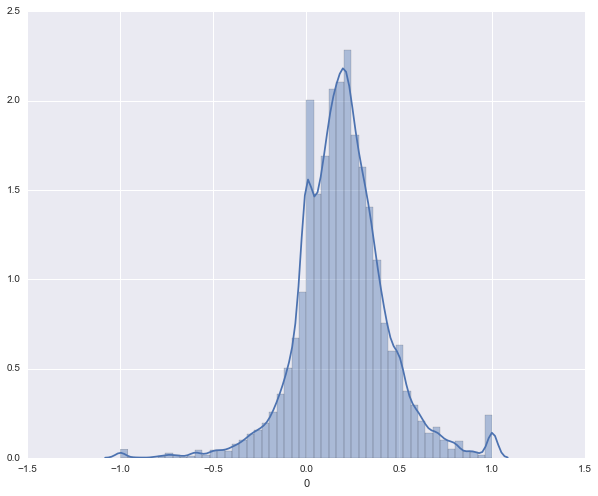

In [41]:
sns.distplot(X[0])

In [193]:
X = pivot_feature(combo, feature='polarity', limit=None, decomp='factor')
y = df[['score_lvl_1', 'score_lvl_2', 'score_lvl_3']]

In [160]:
# combine two features
X2 = pivot_feature(combo, feature='review_stars', limit=None, decomp='factor')
# X3 = pivot_feature(combo, feature='compound', limit=None, decomp='factor')
X = np.hstack((X, X2)) 
# X = np.hstack((X, X2, X3))

In [194]:
# combine X with non-review features
# X = np.hstack((X, df[['inspection_month', 'restaurant_stars']])) # as numerical
X = np.hstack((X, pd.get_dummies(df.inspection_month))) # as categorical
# X = np.hstack((X, pd.get_dummies(df.restaurant_attributes_price_range))) # as categorical
# X = np.hstack((X, df[['previous_inspection_delta']]))
# X = np.hstack((X, pd.get_dummies(df.restaurant_city))) # as categorical

In [195]:
#bool

# selects = df[['restaurant_attributes_accepts_credit_cards', 'restaurant_attributes_coat_check', 'restaurant_attributes_good_for_dancing', 'restaurant_attributes_good_for_groups', 'restaurant_attributes_good_for_latenight', 'restaurant_attributes_happy_hour', 'restaurant_attributes_has_tv', 'restaurant_attributes_outdoor_seating', 'restaurant_attributes_take_out',  'restaurant_attributes_takes_reservations', 'restaurant_attributes_waiter_service', 'restaurant_attributes_wheelchair_accessible']].astype(int)
everything = df[['restaurant_attributes_accepts_credit_cards', 'restaurant_attributes_byob', 'restaurant_attributes_caters', 'restaurant_attributes_coat_check', 'restaurant_attributes_corkage', 'restaurant_attributes_delivery', 'restaurant_attributes_dietary_restrictions_dairy_free', 'restaurant_attributes_dietary_restrictions_gluten_free', 'restaurant_attributes_dietary_restrictions_halal', 'restaurant_attributes_dietary_restrictions_kosher', 'restaurant_attributes_dietary_restrictions_soy_free', 'restaurant_attributes_dietary_restrictions_vegan', 'restaurant_attributes_dietary_restrictions_vegetarian', 'restaurant_attributes_dogs_allowed', 'restaurant_attributes_drive_thr', 'restaurant_attributes_good_for_dancing', 'restaurant_attributes_good_for_groups', 'restaurant_attributes_good_for_breakfast', 'restaurant_attributes_good_for_brunch', 'restaurant_attributes_good_for_dessert', 'restaurant_attributes_good_for_dinner', 'restaurant_attributes_good_for_latenight', 'restaurant_attributes_good_for_lunch', 'restaurant_attributes_good_for_kids', 'restaurant_attributes_happy_hour', 'restaurant_attributes_has_tv', 'restaurant_attributes_open_24_hours', 'restaurant_attributes_order_at_counter', 'restaurant_attributes_outdoor_seating',  'restaurant_attributes_payment_types_amex', 'restaurant_attributes_payment_types_cash_only', 'restaurant_attributes_payment_types_discover', 'restaurant_attributes_payment_types_mastercard', 'restaurant_attributes_payment_types_visa', 'restaurant_attributes_take_out',  'restaurant_attributes_takes_reservations', 'restaurant_attributes_waiter_service', 'restaurant_attributes_wheelchair_accessible', ]].astype(int)
X = np.hstack((X, everything))

In [202]:
#numerical
# everything = df[['restaurant_latitude', 'restaurant_longitude', 'previous_inspection_delta', 'restaurant_hours_friday_close', 'restaurant_hours_friday_open', 'restaurant_hours_monday_close', 'restaurant_hours_monday_open', 'restaurant_hours_saturday_close', 'restaurant_hours_saturday_open', 'restaurant_hours_sunday_close', 'restaurant_hours_sunday_open', 'restaurant_hours_thursday_close', 'restaurant_hours_thursday_open', 'restaurant_hours_tuesday_close', 'restaurant_hours_tuesday_open', 'restaurant_hours_wednesday_close', 'restaurant_hours_wednesday_open']]
# selects = df[['restaurant_latitude']].apply(lambda x: x.fillna(x.median()))
# X = np.hstack((X, selects))

def long_lat(x):
    lbl_enc = LabelEncoder()
    temp = lbl_enc.fit_transform(x).astype(float)
    x = pd.DataFrame(temp / temp.max())
    return x
xlat = long_lat(df.restaurant_latitude)
xlong = long_lat(df.restaurant_longitude)
X = np.hstack((X, xlat, xlong))

In [253]:
# # bin time delta data
bin_size = 50
tdmax = combo.review_delta.max()
tdmin = combo.review_delta.min()
combo['review_delta_bin'] = pd.cut(combo["review_delta"], np.arange(tdmin, tdmax, bin_size))
lbl_enc = LabelEncoder()
combo.review_delta_bin = lbl_enc.fit_transform(combo.review_delta_bin)
bins = pd.concat([combo[['inspection_id', 'enumerated_review_delta']], pd.get_dummies(combo.review_delta_bin, prefix='review_delta_bin')], axis=1)

for i in range(len(bins.columns - ['inspection_id', 'enumerated_review_delta'])):
    t = pivot_feature(bins, feature='review_delta_bin_'+str(i), limit=None, decomp='factor')
    X = np.hstack((X, t))

# # bin previous_inspection_delta data
bin_size = 14
tdmax = df.previous_inspection_delta.max()
tdmin = df.previous_inspection_delta.min()
df['previous_inspection_delta_bin'] = pd.cut(df["previous_inspection_delta"], np.arange(tdmin, tdmax, bin_size))
lbl_enc = LabelEncoder()
df.previous_inspection_delta_bin = lbl_enc.fit_transform(df.previous_inspection_delta_bin)
bins = pd.concat([df[['inspection_id']], pd.get_dummies(df.previous_inspection_delta_bin, prefix='previous_inspection_delta_bin')], axis=1)

for i in range(len(bins.columns - ['inspection_id'])):
    X = np.hstack((X, bins[['previous_inspection_delta_bin_'+str(i)]]))

In [196]:
def special_categories_to_matrix(df, cats):
    # need to do it like this because pd.merge causes a memory overload
    t0 = pd.get_dummies(df[cats[0]])
    cats.pop(0)
    for i in cats:
        new_dummies = pd.get_dummies(df[i])
        pbar = ProgressBar(maxval=len(new_dummies.columns)).start()
        for index, column in enumerate(new_dummies.columns):
            if column not in t0.columns:
                t0 = pd.concat([t0, new_dummies[column]], axis=1)
            else:
                t0[column] = t0[column] + new_dummies[column]
            pbar.update(index)
        pbar.finish()
    return t0

cats = ['restaurant_category_1', 'restaurant_category_2', 'restaurant_category_3', 'restaurant_category_4', 'restaurant_category_5', 'restaurant_category_6', 'restaurant_category_7']
X = np.hstack((X, special_categories_to_matrix(df, cats)))
cats = ['restaurant_neighborhood_1', 'restaurant_neighborhood_2', 'restaurant_neighborhood_3']
X = np.hstack((X, special_categories_to_matrix(df, cats)))

100% (99 of 99) |#########################| Elapsed Time: 0:00:03 Time: 0:00:03
100% (87 of 87) |#########################| Elapsed Time: 0:00:01 Time: 0:00:01
100% (51 of 51) |#########################| Elapsed Time: 0:00:00 Time: 0:00:00
100% (24 of 24) |#########################| Elapsed Time: 0:00:00 Time: 0:00:00
100% (11 of 11) |#########################| Elapsed Time: 0:00:00 Time: 0:00:00
100% (2 of 2) |###########################| Elapsed Time: 0:00:00 Time: 0:00:00
100% (9 of 9) |###########################| Elapsed Time: 0:00:00 Time: 0:00:00
100% (1 of 1) |###########################| Elapsed Time: 0:00:00 Time: 0:00:00


In [197]:
ambience_dum = pd.get_dummies(df.restaurant_ambience)[['divey', 'trendy']]
alcohol_dum = pd.get_dummies(df.restaurant_attributes_alcohol)['full_bar']
attire_dum = pd.get_dummies(df.restaurant_attributes_attire)['dressy']
noise_dum = pd.get_dummies(df.restaurant_attributes_noise_level)['very_loud']
smoke_dum = pd.get_dummies(df.restaurant_attributes_smoking)['outdoor']
music_dum = pd.get_dummies(df.restaurant_music)[['dj', 'live']]
park_dum = pd.get_dummies(df.restaurant_parking)['street']
wifi_dum = pd.get_dummies(df.restaurant_attributes_wifi)['no']
# X = np.hstack((X, np.array(pd.concat([ambience_dum, alcohol_dum, attire_dum, noise_dum, smoke_dum, music_dum, park_dum, wifi_dum], axis=1))))
X = np.hstack((X, np.array(pd.concat([ambience_dum, alcohol_dum], axis=1))))
# X = np.hstack((X, ambience_dum))
# X = np.hstack((X, pd.get_dummies(df.restaurant_ambience)))
# X = np.hstack((X, pd.get_dummies(df.restaurant_music)))

In [76]:
y = final[['score_lvl_1', 'score_lvl_2', 'score_lvl_3']]
X = final.drop(['inspection_id', 'score_lvl_1', 'score_lvl_2', 'score_lvl_3'], axis=1)

In [198]:
X = np.hstack((X, pd.get_dummies(df.restaurant_id)))

In [199]:
X = np.hstack((X, tfidf_pivot.groupby('inspection_id').mean()))
# X = np.hstack((X, tfidf))
X.shape

(24430, 2142)

In [7]:
y = final[['score_lvl_1', 'score_lvl_2', 'score_lvl_3']]
X = final.drop(['score_lvl_1', 'score_lvl_2', 'score_lvl_3', 'inspection_id'], axis=1)

In [8]:
# Xnew = joblib.load('pickle_jar/_jar/Xnew_restid_pivot_score_lvl_1')

In [15]:
tfidf_pivot = pd.read_pickle('pickle_jar/lsa_tfidf_2mil_pivot_365_100c')
# tfidf = joblib.load('pickle_jar/full_post_pivot_tfidf_lsa')
# tfidf = joblib.load('pickle_jar/tfidf_preprocessed_ngram3_sublinear_2mil_post_pivot_365')

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVR
from sklearn.linear_model import BayesianRidge

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, f_regression, f_classif, SelectFpr

from sklearn.metrics import mean_squared_error

from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.svm import SVC, SVR
from sklearn.linear_model import Ridge, RidgeClassifier, Lasso, ElasticNet

In [25]:


t0 = time()


estimator_list = [
    ExtraTreesClassifier(),
#     LinearRegression(), 
#     SGDClassifier(n_jobs=-1, random_state=42), 
#     Perceptron(n_jobs=-1, random_state=42),  # gets some nuances
#     SGDRegressor(), # gets some nuances
#     RandomForestClassifier(n_jobs=-1, random_state=42), 
#     RandomForestRegressor(n_jobs=-1, random_state=42),
#     BayesianRidge(), 
#     KNeighborsClassifier(),
#     KNeighborsRegressor(),  # gets some nuances
#     DecisionTreeClassifier(),
#     DecisionTreeRegressor(),
#     GaussianNB(),
# MultinomialNB(),
#     SVR(),
#     LinearSVC(random_state=42),
#     LogisticRegression()
]

for estimator in estimator_list:
    pipeline = Pipeline([
        ('zero_variance_removal', VarianceThreshold()),
        ('k_best', SelectKBest(score_func=f_classif, k=180)),
#         ('no_negative', MinMaxScaler()),
#         ('normalizer', Normalizer(norm='l2')), #  for text classification and clustering
#         ('normalizer', Normalizer(copy=False)),
#         ('scaler', StandardScaler()),
#         ('scaler', StandardScaler(with_mean=False)), #  for sparse matrix
        ('clf', estimator),
])
    print estimator
#     for i in range(1,11):
#         print(i)
#         X = pivot_feature(combo, feature='polarity', limit=i, decomp=None)
#         p1,p2,p3,ytest = raw_fit(X, y, pipeline)
#         raw_scoring(p1,p2,p3,ytest)
#     p1,p2,p3,ytest = raw_fit(np.hstack((X, test_lsa)), y, pipeline)
    p1,p2,p3,ytest = raw_fit(X, y, pipeline)
    raw_scoring(p1,p2,p3,ytest)
    print('\n')


print("{} seconds elapsed".format(time()-t0))



ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
Level 1 accuracy score of 0.390635232482
Level 2 accuracy score of 0.75622134905
Level 3 accuracy score of 0.609855926654
Contest score of 1.14538902329


15.1787350178 seconds elapsed


In [11]:
# baseline scores if guessing median
scores = ['score_lvl_1', 'score_lvl_2', 'score_lvl_3']
newy  = y.copy()
for index, score in enumerate(scores):
#     print("level {}: {}".format(index+1, y[score].value_counts(normalize=True)[guess])) # if just guessing zero
    newy[score] = np.round(newy[score].mean())
raw_scoring(newy.score_lvl_1, newy.score_lvl_2, newy.score_lvl_3, y)
pass

Level 1 accuracy score of 0.100286532951
Level 2 accuracy score of 0.711625051167
Level 3 accuracy score of 0.21874744167
Contest score of 1.20850107659


In [ ]:


xtrain, xtest, ytrain, ytest = train_test_split(X, y.score_lvl_1, random_state=42)
estimator_list = [
#     SGDClassifier(n_jobs=-1), 
#     SGDClassifier(n_jobs=-1, penalty='elasticnet'), 
#     SGDClassifier(n_jobs=-1, penalty='l1'), 
#     Perceptron(n_jobs=-1),  # gets some nuances
#     SGDRegressor(), # gets some nuances
#     RandomForestClassifier(n_jobs=-1, random_state=42), 
#     RandomForestRegressor(n_jobs=-1, random_state=42),
#     AdaBoostClassifier(),
#     AdaBoostRegressor(),
#     GradientBoostingClassifier(), 
#     GradientBoostingRegressor(),
    BayesianRidge(), 
    Ridge(),
    RidgeClassifier(),
    Lasso(),
    ElasticNet(),
    KNeighborsClassifier(),
    KNeighborsRegressor(),
    LinearSVC(),
    SVC(kernel='linear'),
    SVC(kernel='rbf'),
    SVR(),
    ]

# newX = joblib.load('pickle_jar/Xnew_restid_tfidf_pivot_RFC_score_lvl_1')
newX = SelectKBest(score_func=f_classif, k=180).fit_transform(X, y[score])
xtrain, xtest, ytrain, ytest = train_test_split(newX, y, random_state=42)

for est in estimator_list:
    t0 = time()
    pipeline = Pipeline([
        ('zero_variance_removal', VarianceThreshold()),
#             ('k_best', SelectKBest(score_func=f_classif, k=180)),
    #         ('no_negative', MinMaxScaler()),
    #         ('normalizer', Normalizer(norm='l2')), #  for text classification and clustering
    #         ('normalizer', Normalizer(copy=False)),
    #         ('scaler', StandardScaler()),
    #         ('scaler', StandardScaler(with_mean=False)), #  for sparse matrix
        ('clf', est),
    ])

    p1 = pipeline.fit(xtrain, ytrain['score_lvl_1']).predict(xtest)
    p2 = pipeline.fit(xtrain, ytrain['score_lvl_2']).predict(xtest)
    p3 = pipeline.fit(xtrain, ytrain['score_lvl_3']).predict(xtest)
    results = np.dstack((p1, p2, p3))[0]
    score = contest_metric(results, np.array(ytest))
    
    print('{} score of {} in {} seconds'.format(str(est).split('(')[0], score, time() - t0))


BayesianRidge score of nan in 2.21477508545 seconds
Ridge score of nan in 0.374784946442 seconds
RidgeClassifier score of 1.56242501064 in 0.506411075592 seconds
Lasso score of nan in 0.560006856918 seconds
ElasticNet score of nan in 0.866817951202 seconds
KNeighborsClassifier score of 1.46731906853 in 17.437404871 seconds
KNeighborsRegressor score of 1.13566417453 in 18.9276180267 seconds
LinearSVC score of 2.15767006709 in 330.008104086 seconds

In [16]:
y = final[['score_lvl_1', 'score_lvl_2', 'score_lvl_3']]
X = final.drop(['score_lvl_1', 'score_lvl_2', 'score_lvl_3', 'inspection_id'], axis=1)
X = np.hstack((X, pd.get_dummies(df.restaurant_id)))
X = np.hstack((X, tfidf_pivot.groupby('inspection_id').mean()))
# X = np.hstack((X, tfidf))

X.shape

(24430, 3005)

In [151]:
joblib.load('pickle_jar/Xnew_restid_tfidf_pivot_RFC_score_lvl_1').shape

(24430, 785)

In [24]:
# ensemble multiple variations of same model averaging according to score weight
# est = RandomForestRegressor(n_jobs=-1)
# est = RandomForestClassifier(n_jobs=-1)
est = ExtraTreesClassifier(n_jobs=-1, criterion='entropy')
# est = ExtraTreesRegressor()
        
scores = ['score_lvl_1', 'score_lvl_2', 'score_lvl_3']
        
result_list = []
ytrue = []
for score in scores:
    print(score)
    newX = SelectKBest(score_func=f_classif, k=180).fit_transform(X, y[score])
#     newX = joblib.load('pickle_jar/Xnew_restid_tfidf_pivot_RFC_'+score)
    xtrain, xtest, ytrain, ytest = train_test_split(newX, y[score], random_state=42)
    pre_list = []
    for i in range(10):
        model = est.fit(xtrain, ytrain)
        prediction = model.predict(xtest)
        mse = mean_squared_error(ytest, prediction)
        print('iteration {} MSE of {}'.format(i, mse))
        pre_list.append([mse, prediction, est])
    pre_list = sorted(pre_list, reverse=True)
    weighted_list = []
    for i in pre_list:
        weighted_list.append(i + [(1 + pre_list.index(i)) / float(len(pre_list))])
    w_ens = np.average([i[1] for i in weighted_list], axis=0, weights=[i[3] for i in weighted_list])
    ens = np.array([i[1] for i in pre_list]).T.mean(axis=1)
#     ens = np.clip(np.round(np.array([i[1] for i in pre_list]).T.mean(axis=1)), 0, y[score].max())
#     print('ensembled accuracy score of {}'.format(accuracy_score(ytest, ens)))
#     print('weighted ensembled accuracy score of {}'.format(accuracy_score(ytest, w_ens)))
    print('ensembled MSE of {}'.format(mean_squared_error(ytest, ens)))
    print('weighted ensembled MSE of {}'.format(mean_squared_error(ytest, w_ens)))
    # just in case the ensemble is worse than the worst iteration
    if mean_squared_error(ytest, w_ens) < pre_list[0][0]:
        if mean_squared_error(ytest, w_ens) < mean_squared_error(ytest, ens):
            result_list.append(w_ens)
        else:
            print('taking non-weighted')
            result_list.append(ens)
    else:
        print('replacing ensemble')
        result_list.append(pre_list[0][1])
    print('')
    ytrue.append(ytest.tolist())
print("ensembled contest metric of {}".format(contest_metric(np.round(np.array(result_list).T), np.array(ytrue).T)))



score_lvl_1
iteration 0 MSE of 16.1733791749
iteration 1 MSE of 17.4862475442
iteration 2 MSE of 16.231827112
iteration 3 MSE of 16.2151277014
iteration 4 MSE of 16.7282252783
iteration 5 MSE of 15.9885396202
iteration 6 MSE of 16.6046168959
iteration 7 MSE of 16.7378847413
iteration 8 MSE of 18.0361820563
iteration 9 MSE of 16.8425016372
ensembled MSE of 12.5898952194
weighted ensembled MSE of 12.5797553676

score_lvl_2
iteration 0 MSE of 0.418631303209
iteration 1 MSE of 0.38785199738
iteration 2 MSE of 0.37098886706
iteration 3 MSE of 0.391617550753
iteration 4 MSE of 0.3701702685
iteration 5 MSE of 0.40635232482
iteration 6 MSE of 0.362311722331
iteration 7 MSE of 0.378683693517
iteration 8 MSE of 0.397838899804
iteration 9 MSE of 0.362966601179
ensembled MSE of 0.309328749181
weighted ensembled MSE of 0.30347545828

score_lvl_3
iteration 0 MSE of 2.37180746562
iteration 1 MSE of 2.1491486575
iteration 2 MSE of 2.4377865095
iteration 3 MSE of 2.13555992141
iteration 4 MSE of 2.0443

In [53]:
from scipy.stats import pearsonr
pearsonr(pre_list[0], pre_list[5])

(0.32872855045171417, 7.289136490868647e-154)

In [26]:
# ensemble multiple variations of same model averaging according to score weight

        
scores = ['score_lvl_1', 'score_lvl_2', 'score_lvl_3']

meta_pipeline = [
    Pipeline([
            ('scaler', StandardScaler()),
            ('clf', RandomForestRegressor(n_jobs=-1, )),
        ]),
    Pipeline([
            ('scaler', StandardScaler()),
            ('clf', RandomForestClassifier(n_jobs=-1, criterion='gini')),
        ]),
    Pipeline([
            ('scaler', StandardScaler()),
            ('clf', RandomForestClassifier(n_jobs=-1, criterion='entropy')),
        ]),
    Pipeline([
            ('scaler', StandardScaler()),
            ('clf', ExtraTreesClassifier(n_jobs=-1, criterion='gini')),
        ]),
    Pipeline([
            ('scaler', StandardScaler()),
            ('clf', ExtraTreesClassifier(n_jobs=-1, criterion='entropy')),
        ]),
    Pipeline([
            ('scaler', StandardScaler()),
            ('clf', ExtraTreesClassifier(n_estimators=500, n_jobs=-1, criterion='gini')),
        ]),
    Pipeline([
            ('scaler', StandardScaler()),
            ('clf', ExtraTreesClassifier(n_estimators=500, n_jobs=-1, criterion='entropy')),
        ]),
    Pipeline([
            ('scaler', StandardScaler()),
            ('clf', ExtraTreesRegressor(n_jobs=-1)),
        ]),
    ]

result_list = []
advanced_result_list = []
ytrue = []
for score in scores:
    print(score)
    newX = SelectKBest(score_func=f_classif, k=700).fit_transform(X, y[score])
#     newX = joblib.load('pickle_jar/Xnew_restid_tfidf_pivot_RFR_'+score)
    print(newX.shape)
    xtrain, xtest, ytrain, ytest = train_test_split(newX, y[score], random_state=42, test_size=.4)
    pre_list = []
    for pipeline in meta_pipeline:
        model = pipeline.fit(xtrain, ytrain)
        prediction = model.predict(xtest)
        mse = mean_squared_error(ytest, prediction)
        print('{} MSE of {}'.format(str(pipeline.named_steps['clf']).split('(')[0], mse))
        pre_list.append([mse, prediction, pipeline])
    pre_list = sorted(pre_list, reverse=True)
    weighted_list = []
    for i in pre_list:
        weighted_list.append(i + [(1 + pre_list.index(i)) / float(len(pre_list))])
    w_ens = np.average([i[1] for i in weighted_list], axis=0, weights=[i[3] for i in weighted_list])
    ens = np.array([i[1] for i in pre_list]).T.mean(axis=1)

    print('ensembled MSE of {}'.format(mean_squared_error(ytest, ens)))
    print('weighted ensembled MSE of {}'.format(mean_squared_error(ytest, w_ens)))
    result_list.append(w_ens)
    advanced_result_list.append([i[1] for i in pre_list])
    print('\n')
    ytrue.append(ytest.tolist())
print("ensembled contest metric of {}".format(contest_metric(np.array(result_list).T, np.array(ytrue).T)))




score_lvl_1
(24430, 700)
RandomForestRegressor MSE of 13.5047267704
RandomForestClassifier MSE of 18.769238641
RandomForestClassifier MSE of 19.2852026197
ExtraTreesClassifier MSE of 16.1957634056
ExtraTreesClassifier MSE of 15.2038477282
ExtraTreesClassifier MSE of 13.5388866148
ExtraTreesClassifier MSE of 13.9783053623
ExtraTreesRegressor MSE of 12.7452056897
ensembled MSE of 11.29874079
weighted ensembled MSE of 10.5884167783


score_lvl_2
(24430, 700)
RandomForestRegressor MSE of 0.384001227998
RandomForestClassifier MSE of 0.450573065903
RandomForestClassifier MSE of 0.439214081048
ExtraTreesClassifier MSE of 0.380065493246
ExtraTreesClassifier MSE of 0.350184199754
ExtraTreesClassifier MSE of 0.346090871879
ExtraTreesClassifier MSE of 0.330024559967
ExtraTreesRegressor MSE of 0.360095169873
ensembled MSE of 0.295788781084
weighted ensembled MSE of 0.28876204547


score_lvl_3
(24430, 700)
RandomForestRegressor MSE of 2.08672022104
RandomForestClassifier MSE of 2.43839541547
Random

In [345]:
p_list = []
reconstituted_ytest = []
for i in range(3):

#     blendxtrain, blendxtest, blendytrain, blendytest = train_test_split(np.array(advanced_result_list[i]).T, np.array(ytrue[i]).T)
    blendxtrain, blendxtest, blendytrain, blendytest = train_test_split(np.array(result_list)[i].reshape((-1,1)), np.array(ytrue)[i])

    clf = GradientBoostingRegressor(loss='huber', n_estimators=100)
#     clf = LinearRegression()
    clf.fit(blendxtrain, blendytrain)
    prediction = clf.predict(blendxtest)
    p_list.append(prediction)
    reconstituted_ytest.append(blendytest)

contest_metric(np.array(p_list).T, np.array(reconstituted_ytest).T)

0.75344629639588534